In [1]:
import keras
import os
os.environ['KERAS_BACKEND']='tensorflow'
import h5py
import cv2
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1337)  # for reproducibility

from keras.datasets import mnist
from keras.models import Model
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Input, Dense, Convolution2D, Conv2DTranspose, Dropout
from keras.layers import MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.callbacks import TensorBoard

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

print('libs loaded')

/home/ian/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


libs loaded


In [2]:
# perameters

size = 256

(341, 256, 256, 1)
(341, 256, 256, 1)


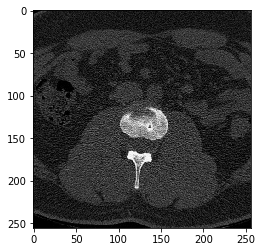

In [3]:
def load_data():
    filenames = []
    for root, dirs, files in os.walk('./data/x'):
        for name in files:
            filenames.append(os.path.join(root, name).split('/')[-1])

    num = len(filenames)
    size = 256
    data_shape = (num, size, size)
    X = np.zeros(data_shape)
    Y = np.zeros(data_shape)
    
    for i in range(num):
        f = filenames[i]
        img = np.array(cv2.imread('./data/x/' + f, 0))
        img2 = np.array(cv2.imread('./data/y/' + f, 0))
        X[i, :, :] = img
        Y[i, :, :] = img2
    
    X = X.reshape(num, size, size, 1)
    Y = Y.reshape(num, size, size, 1)
    
    X = X.astype('float32')
    Y = Y.astype('float32')
    
    X /= 255
    Y /= 255
    
    print(X.shape)
    
    return X, Y

X_train, Y_train = load_data()
print(X_train.shape)
plt.imshow(X_train[0,:,:,0], cmap='gray')

In [4]:
# crf https://github.com/sadeepj/crfasrnn_keras
# c2 64 c2 64 val_loss: 0.0030 - val_acc: 0.9601
# c2 64 dc2 64 val_loss: 0.0027 - val_acc: 0.9603 no hole

# perameters
#dr = 6
#

# Network
input_img = Input(shape=(size, size, 1))

X = Convolution2D(1, (3, 3), padding='same', input_shape=(size,size,1))(input_img)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Convolution2D(64, (3, 3), padding='same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = MaxPooling2D((2,2))(X)

X = Convolution2D(64, (3, 3), padding='same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Convolution2D(128, (3, 3), padding='same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = MaxPooling2D((2,2))(X)

code = X

#Conv2DTranspose
X = UpSampling2D((2,2))(code)

X = Conv2DTranspose(128, (3, 3), padding='same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Conv2DTranspose(64, (3, 3), padding='same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = UpSampling2D((2,2))(X)

X = Conv2DTranspose(64, (3, 3), padding='same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Conv2DTranspose(1, (3, 3), padding='same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

#X = Dropout(0.2)(X)

output_img = X

# model
model = Model(inputs=input_img, outputs=output_img)
print (model.output_shape)

# optimizer
opt = keras.optimizers.Adam(lr=0.0001)

model.compile(optimizer=opt,
              loss='mse',
              metrics=['accuracy'])

# logs
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_grads=True, write_images=True)


(None, 256, 256, 1)


In [5]:
# training
model.fit(X_train, Y_train,
                validation_split=0.3,
                epochs=60,
                batch_size=10,
                shuffle=True,
                callbacks=[tensorboard])

"""
Epoch 20/20
60000/60000 [==============================] - 7s - loss: 0.0398
"""


Train on 238 samples, validate on 103 samples
Epoch 1/60
238/238 [==============================] - 6s 25ms/step - loss: 0.2332 - acc: 0.7538 - val_loss: 0.5499 - val_acc: 0.6181
Epoch 2/60
238/238 [==============================] - 4s 18ms/step - loss: 0.0742 - acc: 0.9070 - val_loss: 0.5246 - val_acc: 0.6948
Epoch 3/60
238/238 [==============================] - 4s 18ms/step - loss: 0.0425 - acc: 0.9248 - val_loss: 0.1039 - val_acc: 0.8954
Epoch 4/60
238/238 [==============================] - 4s 18ms/step - loss: 0.0293 - acc: 0.9353 - val_loss: 0.0323 - val_acc: 0.9369
Epoch 5/60
238/238 [==============================] - 4s 18ms/step - loss: 0.0222 - acc: 0.9417 - val_loss: 0.0344 - val_acc: 0.9349
Epoch 6/60
238/238 [==============================] - 4s 18ms/step - loss: 0.0184 - acc: 0.9451 - val_loss: 0.0345 - val_acc: 0.9331
Epoch 7/60
238/238 [==============================] - 4s 18ms/step - loss: 0.0155 - acc: 0.9475 - val_loss: 0.0307 - val_acc: 0.9357
Epoch 8/60
238/238 [===

'\nEpoch 20/20\n60000/60000 [==============================] - 7s - loss: 0.0398\n'

In [6]:
# save
model.save('./save/model.h5')   # HDF5 file, you have to pip3 install h5py if don't have it
del model  # deletes the existing model

In [7]:
# load
model = load_model('./save/model.h5')

(1, 256, 256, 1)


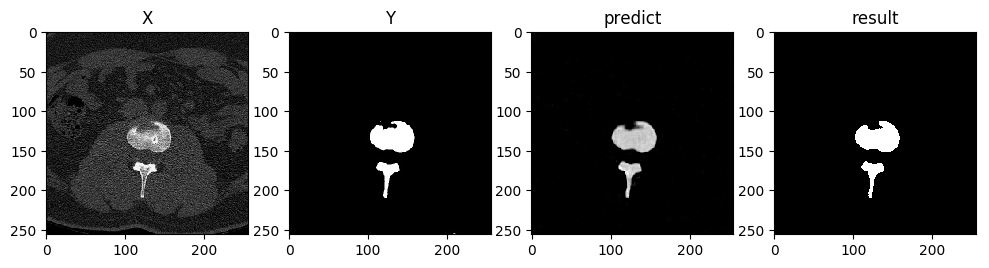

(1, 256, 256, 1)


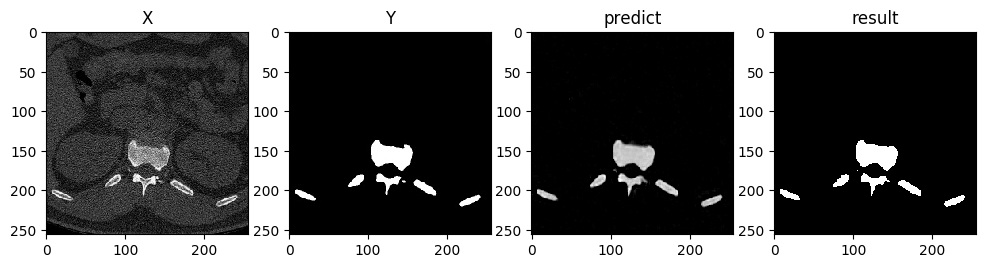

(1, 256, 256, 1)


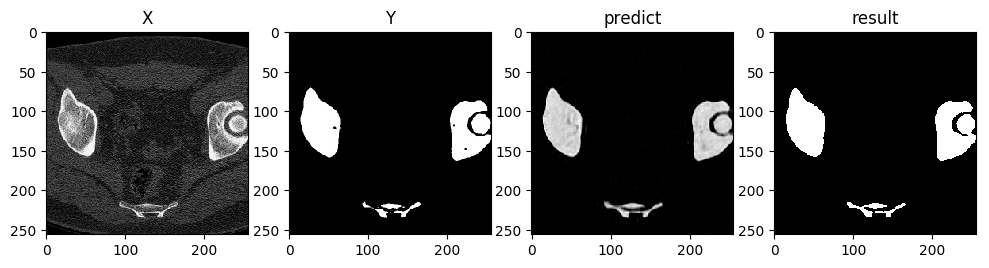

(1, 256, 256, 1)


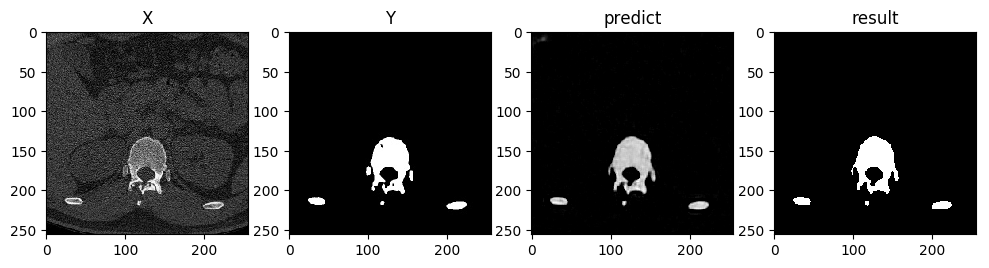

(1, 256, 256, 1)


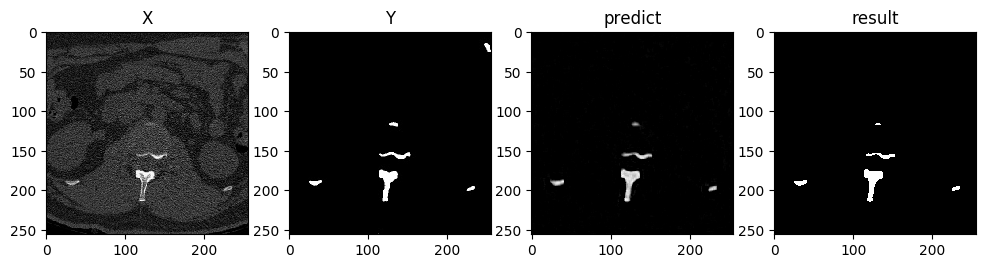

(1, 256, 256, 1)


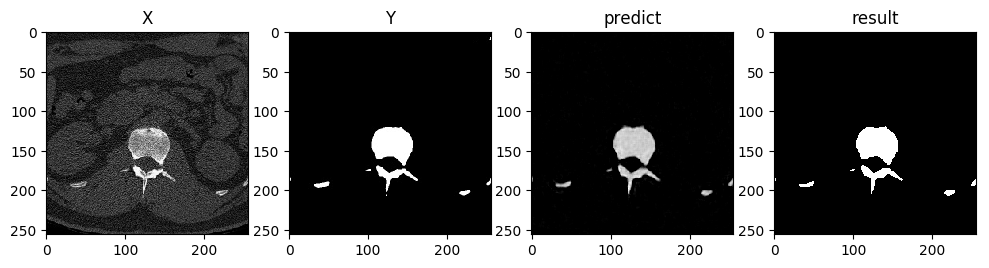

(1, 256, 256, 1)


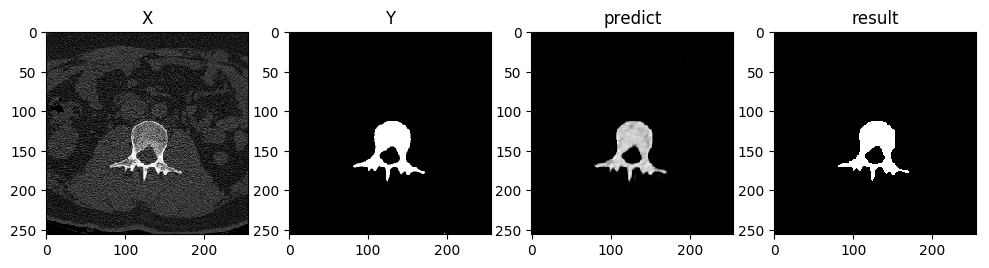

(1, 256, 256, 1)


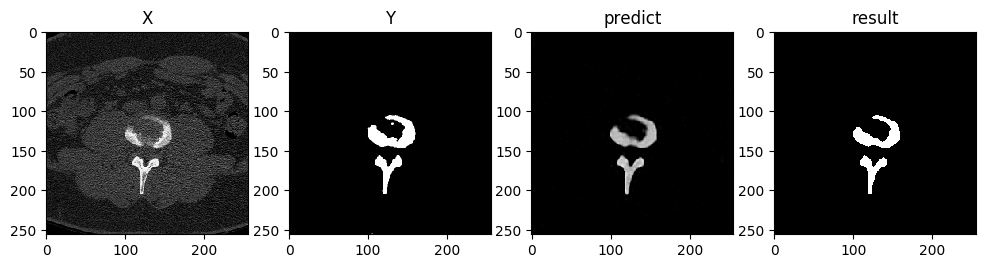

(1, 256, 256, 1)


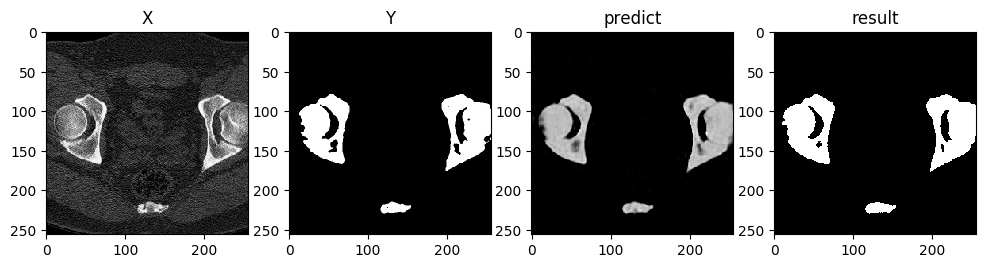

(1, 256, 256, 1)


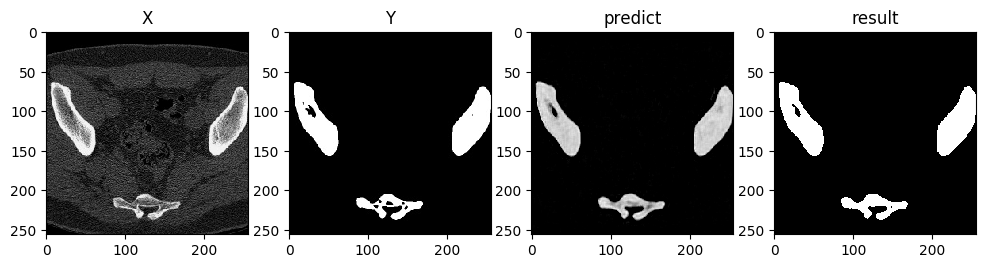

(1, 256, 256, 1)


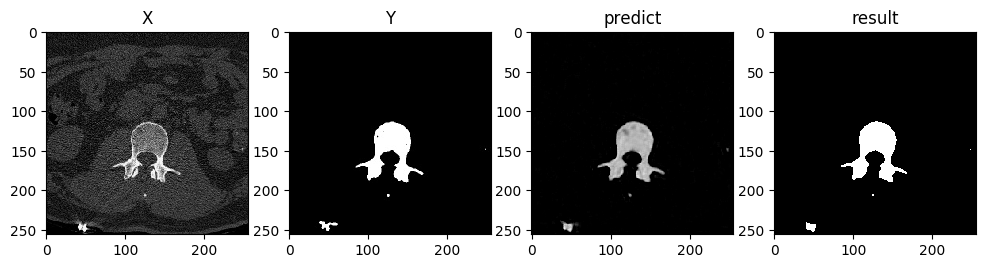

In [8]:
#num = 3
for num in range(0, 11):

    X = X_train[num:num+1]
    Y = Y_train[num:num+1]

    img = model.predict(X)
    img2 = img > 0.5
    print(img.shape)


    plt.figure(num=None, figsize=(12, 15), dpi=100, facecolor='w', edgecolor='k')

    plt.subplot(141), plt.title('X'), plt.imshow(X.reshape(size,size), cmap='gray')

    plt.subplot(142), plt.title('Y'), plt.imshow(Y.reshape(size,size), cmap='gray')

    plt.subplot(143), plt.title('predict'), plt.imshow(img.reshape(size,size), cmap='gray')

    plt.subplot(144), plt.title('result'), plt.imshow(img2.reshape(size,size), cmap='gray')

    plt.show()